<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B9_%D0%BF%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8C_(%D1%81_%D0%B1%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%BE%D0%B9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оптимизация инвестиционного портфеля по методу Марковица. (с библиотекой)

Проект "Оптимизация инвестиционного портфеля".

https://github.com/prog815/portfOptim

Енин А.В.

Оренбург - 2020

05.09.2020

Готовим почву для дальнейших экспериментов и создания библиотеки.

## Опубликовано

Опубликовано на [GitHub](), [VC](), [Google.Docs](), [Habr](), [VK](), [OK](), [FB](), [Telegram]()

# Источники

[Лучший инвестиционный портфель через симуляцию Монте-Карло в Python](https://www.machinelearningmastery.ru/best-investment-portfolio-via-monte-carlo-simulation-in-python-53286f3fe93/) 

[Портфельная теория Марковица (Википедиа)](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%82%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D0%9C%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%B8%D1%86%D0%B0)

# Загрузка данных по котировкам
Используем данные с сервиса [Yahoo.Finance](https://finance.yahoo.com/most-active)

In [1]:
! pip install yfinance

In [2]:
import yfinance as yf

Берем несколько акций американского рынка (см. https://finance.yahoo.com/most-active) за последние 3 месяца.

In [3]:
data = yf.download(['AAPL','GE','BAC','AMD','PLUG','F'],period='3mo')

[*********************100%***********************]  6 of 6 completed


# Курсы закрытия
В расчетах будем использовать дневные курсы закрытия

In [4]:
closeData = data.Close
closeData

,AAPL,AMD,BAC,F,GE,PLUG
Date,,,,,,
2020-06-09,85.997498,56.389999,28.219999,7.24,8.020,5.10
2020-06-10,88.209999,57.439999,26.600000,6.81,7.610,5.66
2020-06-11,83.974998,52.830002,23.930000,6.13,6.950,4.75
2020-06-12,84.699997,53.500000,24.780001,6.46,7.250,5.06
2020-06-15,85.747498,54.680000,25.150000,6.50,7.240,5.21
...,...,...,...,...,...,...
2020-09-02,131.399994,90.220001,26.020000,6.95,6.440,13.14
2020-09-03,120.879997,82.540001,25.660000,6.82,6.320,11.55
2020-09-04,120.959999,82.010002,26.540001,6.90,6.420,11.76


## Графики курсов

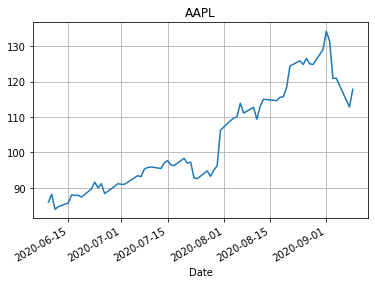

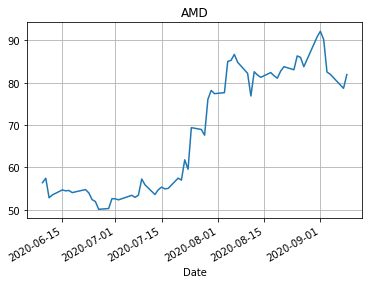

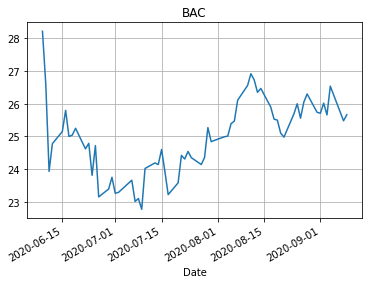

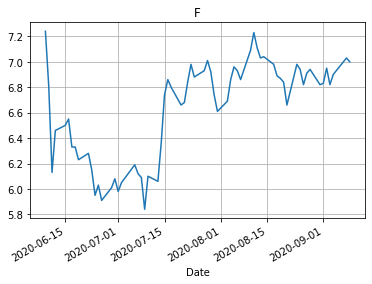

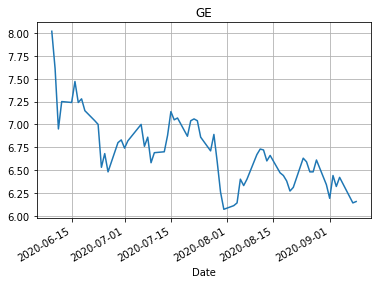

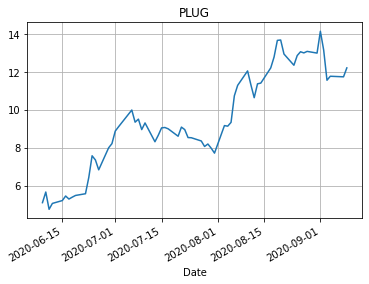

In [5]:
import matplotlib.pyplot as plt

for name in closeData.columns:
    closeData[name].plot()
    plt.grid()
    plt.title(name)
    plt.show()

# Изменение курсов
Далее понадобятся относительные изменения к предыдущему дню.

In [6]:
dCloseData = closeData.pct_change()
dCloseData

,AAPL,AMD,BAC,F,GE,PLUG
Date,,,,,,
2020-06-09,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-10,0.025728,0.018620,-0.057406,-0.059392,-0.051122,0.109804
2020-06-11,-0.048010,-0.080258,-0.100376,-0.099853,-0.086728,-0.160777
2020-06-12,0.008634,0.012682,0.035520,0.053834,0.043165,0.065263
2020-06-15,0.012367,0.022056,0.014931,0.006192,-0.001379,0.029644
...,...,...,...,...,...,...
2020-09-02,-0.020718,-0.021263,0.012058,0.017570,0.040388,-0.070064
2020-09-03,-0.080061,-0.085125,-0.013836,-0.018705,-0.018634,-0.121005
2020-09-04,0.000662,-0.006421,0.034295,0.011730,0.015823,0.018182


## Графики относительных изменений курсов

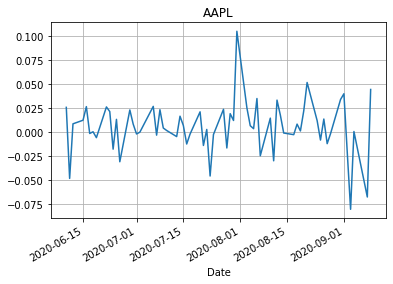

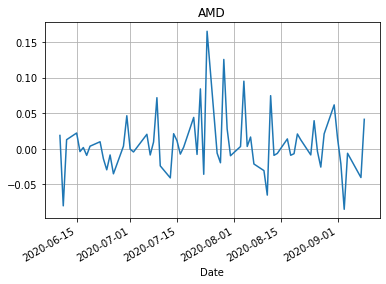

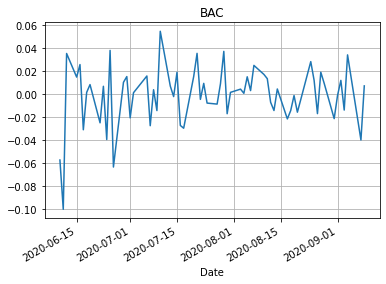

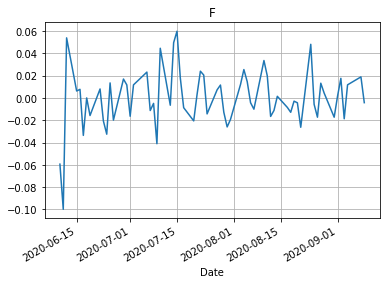

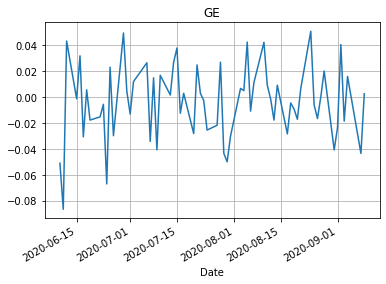

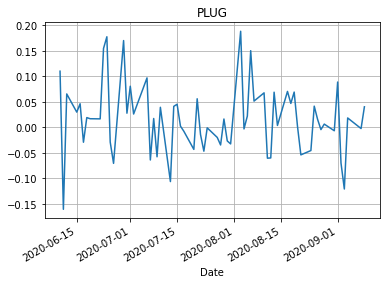

In [7]:
for name in dCloseData.columns:
    dCloseData[name].plot()
    plt.title(name)
    plt.grid()
    plt.show()

## Средняя доходность
Средняя дневная доходность по каждой акции для расчета доходности портфеля.

In [8]:
dohMean = dCloseData.mean()
dohMean

AAPL    0.005297
AMD     0.006701
BAC    -0.001142
F      -0.000187
GE     -0.003711
PLUG    0.016005
dtype: float64

# Ковариация
Для расчета риска портфеля потребуется ковариационная матрица.

In [9]:
cov = dCloseData.cov()
cov

,AAPL,AMD,BAC,F,GE,PLUG
AAPL,0.000746,0.000496,0.000159,0.000017,0.000087,0.000623
AMD,0.000496,0.001777,0.000173,0.000018,-0.000087,0.000388
BAC,0.000159,0.000173,0.000677,0.000451,0.000540,0.000372
F,0.000017,0.000018,0.000451,0.000682,0.000586,0.000364
GE,0.000087,-0.000087,0.000540,0.000586,0.000836,0.000352
PLUG,0.000623,0.000388,0.000372,0.000364,0.000352,0.004747


# Подгружаем библиотеку

In [10]:
! pip install git+https://github.com/prog815/portfOptim

  Cloning https://github.com/prog815/portfOptim to /tmp/pip-req-build-qtvig527
  Running command git clone -q https://github.com/prog815/portfOptim /tmp/pip-req-build-qtvig527
  Created wheel for portfOptim: filename=portfOptim-0.0.3-cp36-none-any.whl size=3112 sha256=3a601ff380a30e14b0105a30f8f8a71e980aa1c9d86c5acba4ab0a8e43fc4aea
  Stored in directory: /tmp/pip-ephem-wheel-cache-qaahsh5h/wheels/ef/8b/25/89eadb83696c6f13f7c19550677e232c32182db7884471ca86
Successfully built portfOptim


In [11]:
import portfOptim

In [12]:
help(portfOptim)

Help on package portfOptim:

NAME
    portfOptim

PACKAGE CONTENTS


FUNCTIONS
    dohPortf(r, doh)
        Доходность портфеля
        
        Аргументы:
        r - массив долей инструментов в портфеле
        doh - массив доходностей каждого инструмента в портфеле
        
        Возвращает число (суммарную доходность портфеля)
        
        Пример:
        dohPortf(r=[0.1,0.5,0.4],doh=[-0.3,0.4,0.1])
    
    portfSharpOptim(doh, cov)
        Поиск оптимизированного портфеля
        (на основе https://www.mlq.ai/python-for-finance-portfolio-optimization/)
        
        Аргументы:
        doh - массив доходностей каждого инструмента в портфеле
        cov - ковариационная матрица инструментов в портфеле
        
        Возвращает массив весов портфеля
        
        Пример:
        portfSharpOptim(dohMean.values,cov.values)
        >>> array([4.07396945e-01, 2.64008207e-01, 2.39608680e-17, 2.03830008e-17,
           8.89045781e-18, 3.28594848e-01])
    
    randPortf(cnt)

# Случайный портфель
Будем генерить случайные портфели. В них сумма долей равна 1 (единице).

In [13]:
import numpy as np

cnt = len(dCloseData.columns)

r = portfOptim.randPortf(cnt)
print(r)
print(r.sum())

[0.05481412 0.14375504 0.17773696 0.27558913 0.14415657 0.20394819]
1.0


# Доходность портфеля
Доходность портфеля считаем как сумму долей доходностей по каждой акции в портфеле.

In [14]:
r = portfOptim.randPortf(cnt)
print(r)
d = portfOptim.dohPortf(r,dohMean.values)
print(d)

[0.08318576 0.10964448 0.35697117 0.39463671 0.03499175 0.02057013]
0.0008934255554119253


# Риск портфеля
Риск портфеля считаем через матричные произведения долей портфеля и матрицы ковариации.

In [15]:
# def riskPortf(r):
#     return np.sqrt(np.matmul(np.matmul(r,cov.values),r))

r = portfOptim.randPortf(cnt)
print(r)
rs = portfOptim.riskPortf(r,cov.values)
print(rs)

[0.55037723 0.08281006 0.05012596 0.13188503 0.09639314 0.08840857]
0.021745698045504573


# Облако портфелей
Сгенерируем множество портфелей и выведем результат на график риск-доходность. Найдем параметры оптимального портфеля по минимальному риску и по максимальному коэффициенту Шарпа. Сравним с данными усредненного портфеля.

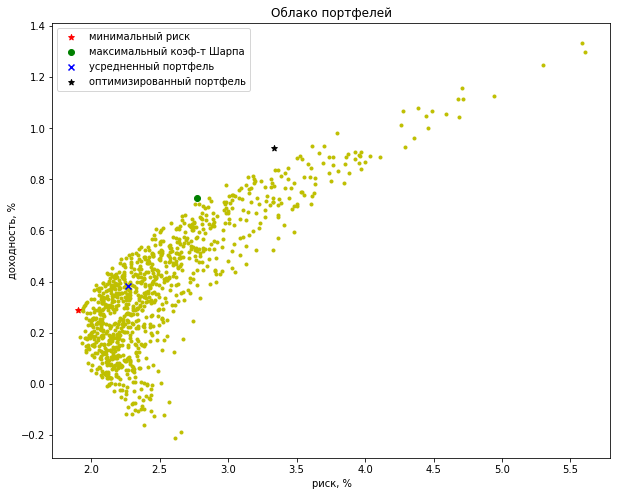

In [16]:
N = 1000

risk = np.zeros(N)
doh = np.zeros(N)
portf = np.zeros((N,cnt))

for n in range(N):
    r = portfOptim.randPortf(cnt)

    portf[n,:] = r
    risk[n] = portfOptim.riskPortf(r,cov.values)
    doh[n] = portfOptim.dohPortf(r,dohMean.values)

plt.figure(figsize=(10,8))

plt.scatter(risk*100,doh*100,c='y',marker='.')
plt.xlabel('риск, %')
plt.ylabel('доходность, %')
plt.title("Облако портфелей")

min_risk = np.argmin(risk)
plt.scatter([(risk[min_risk])*100],[(doh[min_risk])*100],c='r',marker='*',label='минимальный риск')

maxSharpKoef = np.argmax(doh/risk)
plt.scatter([risk[maxSharpKoef]*100],[doh[maxSharpKoef]*100],c='g',marker='o',label='максимальный коэф-т Шарпа')

r_mean = np.ones(cnt)/cnt
risk_mean = portfOptim.riskPortf(r_mean,cov.values)
doh_mean = portfOptim.dohPortf(r_mean,dohMean.values)
plt.scatter([risk_mean*100],[doh_mean*100],c='b',marker='x',label='усредненный портфель')

r_optim = portfOptim.portfSharpOptim(dohMean.values,cov.values)
risk_optim = portfOptim.riskPortf(r_optim,cov.values)
doh_optim = portfOptim.dohPortf(r_optim,dohMean.values)
plt.scatter([risk_optim*100],[doh_optim*100],c='k',marker='*',label='оптимизированный портфель')

plt.legend()

plt.show()



Выведем данные найденных портфелей.

In [17]:
import pandas as pd

print('---------- Минимальный риск ----------')
print()
print("риск = %1.2f%%" % (float(risk[min_risk])*100.))
print("доходность = %1.2f%%" % (float(doh[min_risk])*100.)) 
print()
print(pd.DataFrame([portf[min_risk]*100],columns=dCloseData.columns,index=['доли, %']).T)
print()

print('---------- Максимальный коэффициент Шарпа ----------')
print()
print("риск = %1.2f%%" % (float(risk[maxSharpKoef])*100.))
print("доходность = %1.2f%%" % (float(doh[maxSharpKoef])*100.)) 
print()
print(pd.DataFrame([portf[maxSharpKoef]*100],columns=dCloseData.columns,index=['доли, %']).T)
print()

print('---------- Средний портфель ----------')
print()
print("риск = %1.2f%%" % (float(risk_mean)*100.)) 
print("доходность = %1.2f%%" % (float(doh_mean)*100.)) 
print()
print(pd.DataFrame([r_mean*100],columns=dCloseData.columns,index=['доли, %']).T)
print()

---------- Минимальный риск ----------

риск = 1.90%
доходность = 0.29%

        доли, %
AAPL  39.582179
AMD   13.575239
BAC    4.841173
F     36.688012
GE     4.315713
PLUG   0.997684

---------- Максимальный коэффициент Шарпа ----------

риск = 2.77%
доходность = 0.73%

        доли, %
AAPL  49.469456
AMD   21.842758
BAC    2.281438
F      1.913964
GE     3.577156
PLUG  20.915227

---------- Средний портфель ----------

риск = 2.27%
доходность = 0.38%

        доли, %
AAPL  16.666667
AMD   16.666667
BAC   16.666667
F     16.666667
GE    16.666667
PLUG  16.666667



# Выводы
Повторили классический метод расчета долей инвестиционного портфеля. Получили вполне конкретные результаты.

Оптимизация портфеля по методу Марковица предполагает сохранение параметров в будущем (корреляций между отдельными инструментами и уровня их доходности). Но это не гарантировано. В следующих работах предстоит это проверить.

Понятно, что положительного результата от обозначенной выше проверки ожидать не стоит. Но тогда можно поискать как доработать метод Марковица для получения более гарантированного дохода в будущем. Вот тема для еще одного исследования.